# Dataset to Sequence

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow as tf

# Check if TensorFlow detects GPU
print("Is TensorFlow using GPU?", tf.config.list_physical_devices('GPU'))


Is TensorFlow using GPU? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
df = pd.read_csv('/content/drive/MyDrive/filtered.csv')

In [6]:
df.head()

,Unnamed: 0,Sport_-1,drug_1896,equity_1896,drug_1900,equity_1900,drug_1904,equity_1904,drug_1906,equity_1906,...,CV_1980,CV_1984,CV_1988,CV_1992,CV_1996,CV_2000,CV_2004,CV_2008,CV_2012,CV_2016
0,0,Alpine Skiing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.941454,0.810152,0.975410,1.038671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,Alpinism,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,Archery,0.0,NaN,NaN,0.0,NaN,0.228571,NaN,NaN,...,0.518674,0.486000,0.736622,0.877037,0.872777,0.840279,0.893923,0.819216,0.751548,0.849326
3,3,Art Competitions,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,Athletics,0.0,0.0,NaN,0.0,NaN,0.000000,NaN,0.0,...,1.012697,1.053289,1.032190,0.986700,1.016212,0.982383,0.984688,1.058562,0.964608,0.974802


In [7]:
data_dict = {}

for sport in df['Sport_-1'].unique():
    sport_data = df[df['Sport_-1'] == sport]
    sport_dict = {}

    for variable in ['drug', 'equity', 'popularity', 'normalized_country', 'CV']:
        # Filter the columns that belong to the current variable
        variable_cols = [col for col in df.columns if col.startswith(variable)]

        # Create a DataFrame with years and the corresponding values for this variable
        year_variable_df = sport_data[variable_cols].melt(var_name='Year_Var', value_name=variable)

        # Extract the year from the column names
        year_variable_df['Year'] = year_variable_df['Year_Var'].str.extract('(\d{4})').astype(int)
        year_variable_df = year_variable_df[['Year', variable]].dropna()

        # Add this DataFrame to the sport's dictionary
        sport_dict[variable] = year_variable_df.reset_index(drop=True)

    # Add the sport's dictionary to the main dictionary
    data_dict[sport] = sport_dict

DIctionary is in the structure of,

    "Alpine Skiing": {
        "drug":       # DataFrame for the 'drug' variable
                    Year    drug
                    1896    0.0
                    1900    NaN
                    1904    NaN
                    ...
        "equity":    # DataFrame for the 'equity' variable
                    Year    equity
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "popularity": # DataFrame for the 'popularity' variable
                    Year    popularity
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "normalized_country": # DataFrame for 'normalized_country' variable
                    Year    normalized_country
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "CV":        # DataFrame for 'CV' variable
                    Year    CV
                    1980    0.94154
                    1984    0.810152
                    1988    0.975410
                    ...
    },


    # Similar structure for other sports



In [8]:
df_Athletes_CV = data_dict['Athletics']['CV']
df_Athletes_CV.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


# Processing Data

In [ ]:
print("Number of missing values in 'CV':", df_Athletes_CV['CV'].isnull().sum())


Number of missing values in 'CV': 0


In [ ]:
df_Athletes_CV['CV'] = df_Athletes_CV['CV'].interpolate(method='linear')


In [ ]:
df_Athletes_CV = df_Athletes_CV.sort_values('Year').reset_index(drop=True)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_Athletes_CV['CV_scaled'] = scaler.fit_transform(df_Athletes_CV['CV'].values.reshape(-1, 1))


In [ ]:
#creating lstm input
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [ ]:
window_size = 3  # You can adjust this value
data = df_Athletes_CV['CV_scaled'].values
X, y = create_sequences(data, window_size)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# define visualization function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_training_history(history, metrics=('mse', 'r2_keras')):
    """
    Plot training and validation metrics over epochs.

    Args:
        history: Keras History object after model training.
        metrics: Tuple of metrics to plot. Default is ('mse', 'r2_keras').
    """
    plt.figure(figsize=(12, 4))

    # Plot each metric
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(history.history[metric], label=f'Training {metric.upper()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.upper()}')
        plt.title(f'{metric.upper()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.upper())
        plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and compute MSE and R².

    Args:
        model: Trained model to evaluate.
        X_test: Test input data.
        y_test: Test target data.

    Returns:
        test_mse: Mean Squared Error on the test set.
        test_r2: R² score on the test set.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Reshape y_test if necessary
    if y_test.ndim > 1:
        y_test = y_test.reshape(-1)

    # Compute metrics
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {test_mse}")
    print(f"Test R²: {test_r2}")

    return test_mse, test_r2

def plot_predictions(model, data, window_size, scaler, years, target_column='CV_scaled', title='Actual vs Predicted CV Values Over Years'):
    """
    Plot actual vs predicted values for a given model.

    Args:
        model: Trained model for prediction.
        data: DataFrame or array containing the input data.
        window_size: Size of the sequence window used during training.
        scaler: Scaler object used for scaling the data.
        years: Array of years corresponding to the data.
        target_column: Column name of the scaled target variable in `data`.
        title: Title for the plot.
    """
    # Extract the target column as a NumPy array
    data_values = data[target_column].values

    # Create sequences
    X_all, y_all = create_sequences(data_values, window_size)

    # Reshape for LSTM input
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

    # Make predictions
    y_pred_scaled = model.predict(X_all)

    # Inverse transform predictions and actual values
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_all.reshape(-1, 1))

    # Adjust years to match the prediction length
    adjusted_years = years[window_size:]

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(adjusted_years, y_actual, label='Actual', marker='o')
    plt.plot(adjusted_years, y_pred, label='Predicted', marker='x')
    plt.xlabel('Year')
    plt.ylabel('CV')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Attempt 1: vanilla lstm

In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

In [ ]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', r2_keras])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=15,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=500,                # Maximum number of epochs
    batch_size=1,              # You can adjust this based on your dataset size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1                  # Set to 1 to print progress for each epoch
)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2653 - mse: 0.2653 - r2_keras: -2653288.5000 - val_loss: 0.0760 - val_mse: 0.0760 - val_r2_keras: -759505.1875
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2631 - mse: 0.2631 - r2_keras: -2630804.5000 - val_loss: 0.0702 - val_mse: 0.0702 - val_r2_keras: -701674.0625
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3269 - mse: 0.3269 - r2_keras: -3269147.2500 - val_loss: 0.0645 - val_mse: 0.0645 - val_r2_keras: -645188.0625
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2254 - mse: 0.2254 - r2_keras: -2254318.0000 - val_loss: 0.0589 - val_mse: 0.0589 - val_r2_keras: -589481.2500
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2363 - mse: 0.2363 - r2_keras: -2363479.2500 - val_loss: 0.0536 - val_mse: 0.0536 - val_r2_keras: -536428.5625
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2070 - mse: 0.2070 - r2_keras: -2069852.6250 - val_loss: 0.0486 - val_mse: 0.0

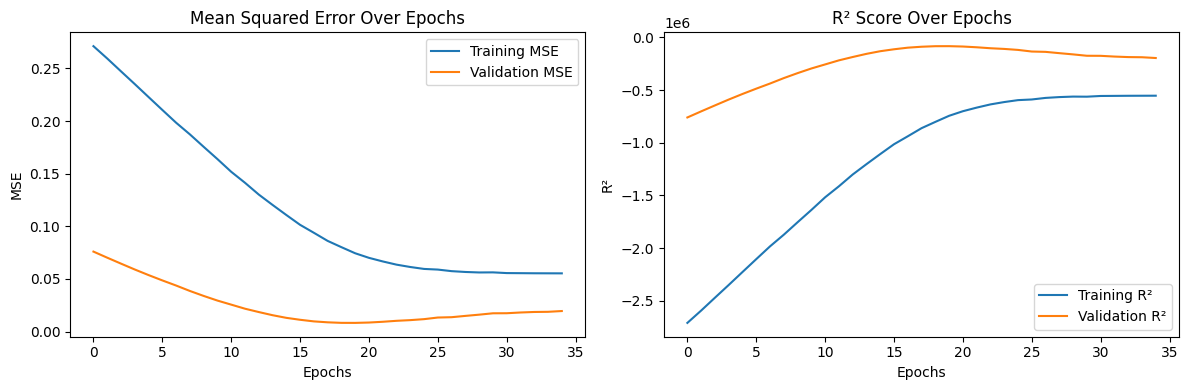

In [ ]:
import matplotlib.pyplot as plt

# Plot MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(history.history['r2_keras'], label='Training R²')
plt.plot(history.history['val_r2_keras'], label='Validation R²')
plt.title('R² Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Reshape y_test if necessary
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Compute R² and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Test MSE: 0.008236003007193318
Test R²: -0.04381289808213973


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


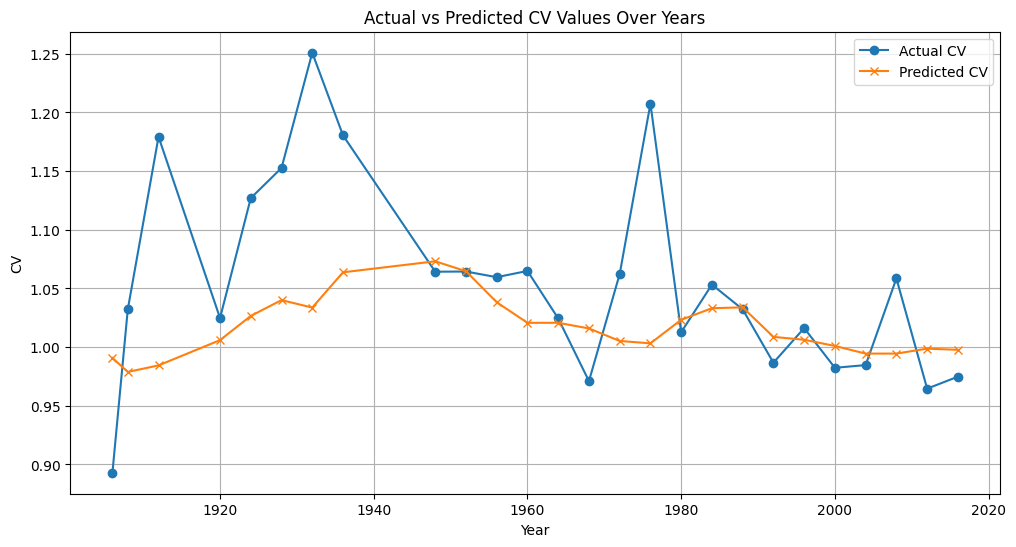

In [ ]:
# Use the same window size as during training
window_size = 3
data = df_Athletes_CV['CV_scaled'].values

# Create sequences using the function defined earlier
X_all, y_all = create_sequences(data, window_size)

# Reshape X_all for LSTM input
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))
y_pred_scaled = model.predict(X_all)
# Inverse transform the predicted values
y_pred = scaler.inverse_transform(y_pred_scaled)

# Inverse transform the actual values
y_actual = scaler.inverse_transform(y_all.reshape(-1, 1))
# Extract the corresponding years from the original dataframe
years = df_Athletes_CV['Year'].values

# Adjust the years array to match the length of predictions
years = years[window_size:]
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(years, y_actual, label='Actual CV', marker='o')
plt.plot(years, y_pred, label='Predicted CV', marker='x')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Predicted CV Values Over Years')
plt.legend()
plt.grid(True)
plt.show()


# Attemp 2: LSTM more no. of hidden units

In [ ]:
model2 = Sequential()
model2.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer2 = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer2, loss='mean_squared_error', metrics=['mse', r2_keras])

In [ ]:
early_stopping2 = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=15,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

In [ ]:
history2 = model2.fit(
    X_train, y_train,
    epochs=500,                # Maximum number of epochs
    batch_size=16,              # You can adjust this based on your dataset size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping2],
    verbose=1                  # Set to 1 to print progress for each epoch
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.3188 - mse: 0.3188 - r2_keras: -65.6231 - val_loss: 0.0943 - val_mse: 0.0943 - val_r2_keras: -70.7309
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3131 - mse: 0.3131 - r2_keras: -76.2441 - val_loss: 0.0934 - val_mse: 0.0934 - val_r2_keras: -70.0395
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2848 - mse: 0.2848 - r2_keras: -83.0728 - val_loss: 0.0925 - val_mse: 0.0925 - val_r2_keras: -69.3538
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3075 - mse: 0.3075 - r2_keras: -73.2379 - val_loss: 0.0916 - val_mse: 0.0916 - val_r2_keras: -68.6766
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3063 - mse: 0.3063 - r2_keras: -70.4321 - val_loss: 0.0907 - val_mse: 0.0907 - val_r2_keras: -68.0089
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3030 - mse: 0.3030 - r2_keras: -63.9434 - val_loss: 0.0899 - val_mse: 0.0899 - val_r2_keras: -67.3508
Epoch 7/500
2/2 ━━━━━━━━━━━━━━

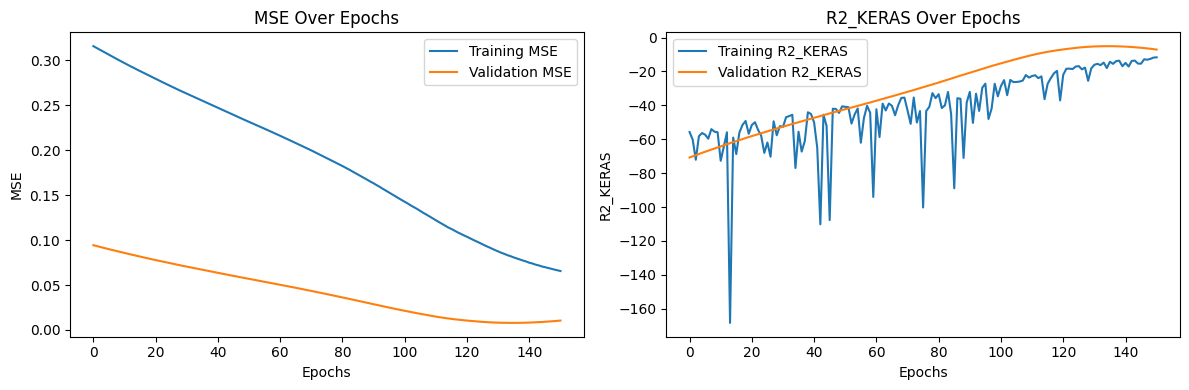

In [ ]:
plot_training_history(history2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


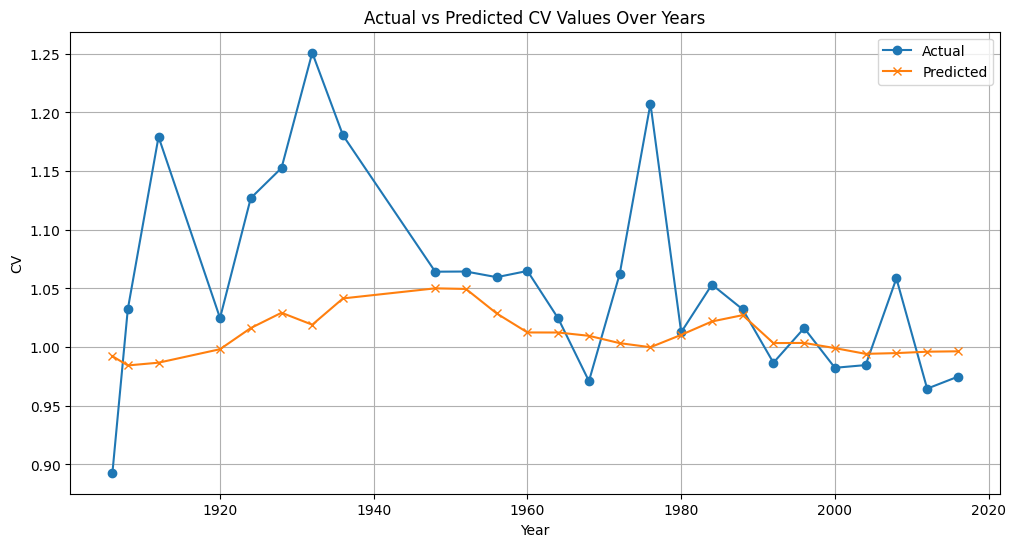

In [ ]:
plot_predictions(model=model2, data=df_Athletes_CV, window_size=3, scaler=scaler, years=df_Athletes_CV['Year'].values)

In [ ]:
y_pred = model2.predict(X_test)

# Reshape y_test if necessary
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Compute R² and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test MSE: 0.007862517330887484
Test R²: 0.0035218546901051306


# Attemp 3: Bideirectional LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Bidirectional(LSTM(units=64)))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer3  = Adam(learning_rate=0.00005)  # Reduced learning rate for finer updates
model3.compile(optimizer=optimizer3, loss='mean_squared_error', metrics=['mse', r2_keras])


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history3 = model3.fit(
    X_train, y_train,
    epochs=500,  # Increased epochs due to the complexity of the model
    batch_size=2,  # Adjusted batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.8310 - mse: 0.8310 - r2_keras: -349.5176 - val_loss: 0.0900 - val_mse: 0.0900 - val_r2_keras: -180.0733
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6763 - mse: 0.6763 - r2_keras: -1202.4685 - val_loss: 0.0873 - val_mse: 0.0873 - val_r2_keras: -172.5479
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4517 - mse: 1.4517 - r2_keras: -328848.6875 - val_loss: 0.0838 - val_mse: 0.0838 - val_r2_keras: -163.0156
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7548 - mse: 0.7548 - r2_keras: -84649.2266 - val_loss: 0.0812 - val_mse: 0.0812 - val_r2_keras: -155.6196
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7630 - mse: 0.7630 - r2_keras: -2944.2620 - val_loss: 0.0781 - val_mse: 0.0781 - val_r2_keras: -147.2270
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3466 - mse: 1.3466 - r2_keras: -9169273.0000 - val_loss: 0.0757 - val_mse: 0.0757 - val_r2_keras: -14

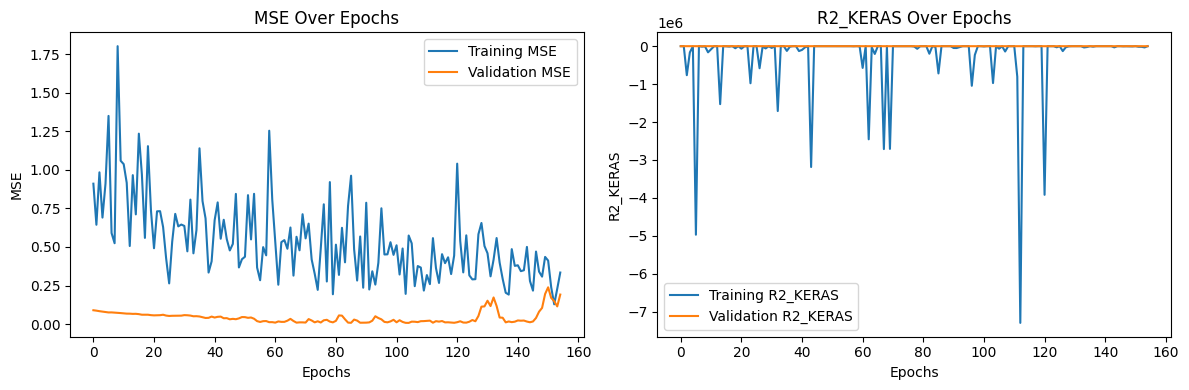

In [ ]:
plot_training_history(history3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


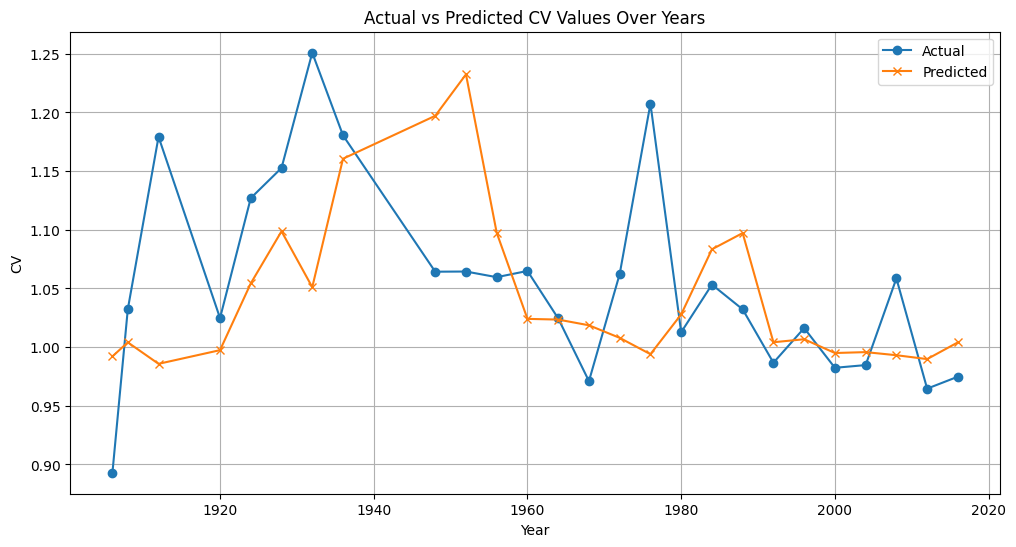

In [ ]:
plot_predictions(model=model3, data=df_Athletes_CV, window_size=3, scaler=scaler, years=df_Athletes_CV['Year'].values)

In [ ]:
y_pred = model3.predict(X_test)

# Reshape y_test if necessary
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Compute R² and MSE
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Test MSE: 0.007995541532751359
Test R²: -0.013337339938809256


# Attempt 4: Bi-directional LSTM reconstucted

In [ ]:
model4 = Sequential()
model4.add(Bidirectional(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())

model4.add(Bidirectional(LSTM(units=128)))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())

model4.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer4  = Adam(learning_rate=0.00005)  # Reduced learning rate for finer updates
model4.compile(optimizer=optimizer4, loss='mean_squared_error', metrics=['mse', r2_keras])


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history4 = model4.fit(
    X_train, y_train,
    epochs=700,  # Increased epochs due to the complexity of the model
    batch_size=4,  # Adjusted batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 2.0414 - mse: 2.0414 - r2_keras: -183.9361 - val_loss: 0.0887 - val_mse: 0.0887 - val_r2_keras: -243.9129
Epoch 2/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8063 - mse: 0.8063 - r2_keras: -229.9098 - val_loss: 0.0879 - val_mse: 0.0879 - val_r2_keras: -241.1933
Epoch 3/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6486 - mse: 0.6486 - r2_keras: -100.1052 - val_loss: 0.0856 - val_mse: 0.0856 - val_r2_keras: -232.0529
Epoch 4/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9830 - mse: 0.9830 - r2_keras: -16048.5303 - val_loss: 0.0827 - val_mse: 0.0827 - val_r2_keras: -220.9414
Epoch 5/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6796 - mse: 0.6796 - r2_keras: -76.2776 - val_loss: 0.0802 - val_mse: 0.0802 - val_r2_keras: -211.1079
Epoch 6/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7278 - mse: 0.7278 - r2_keras: -65.5058 - val_loss: 0.0776 - val_mse: 0.0776 - val_r2_keras: -201.1659
Epoch 7/700
5/5

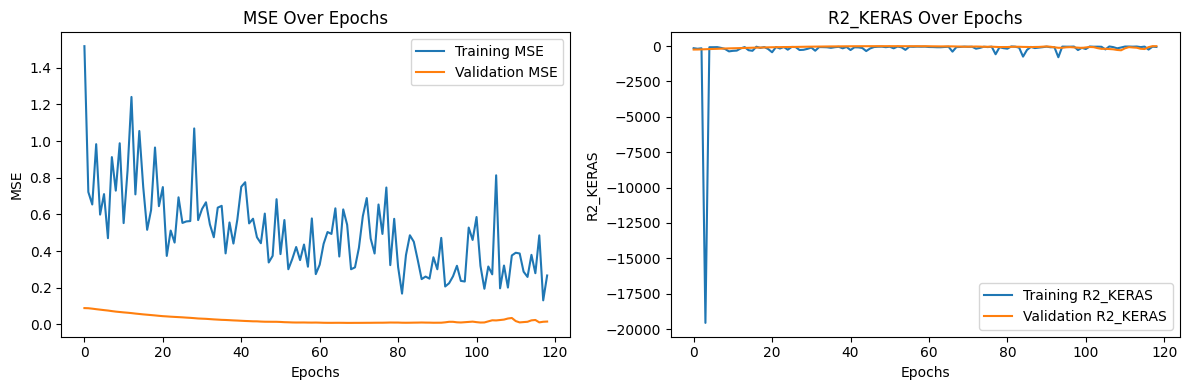

In [ ]:
plot_training_history(history4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


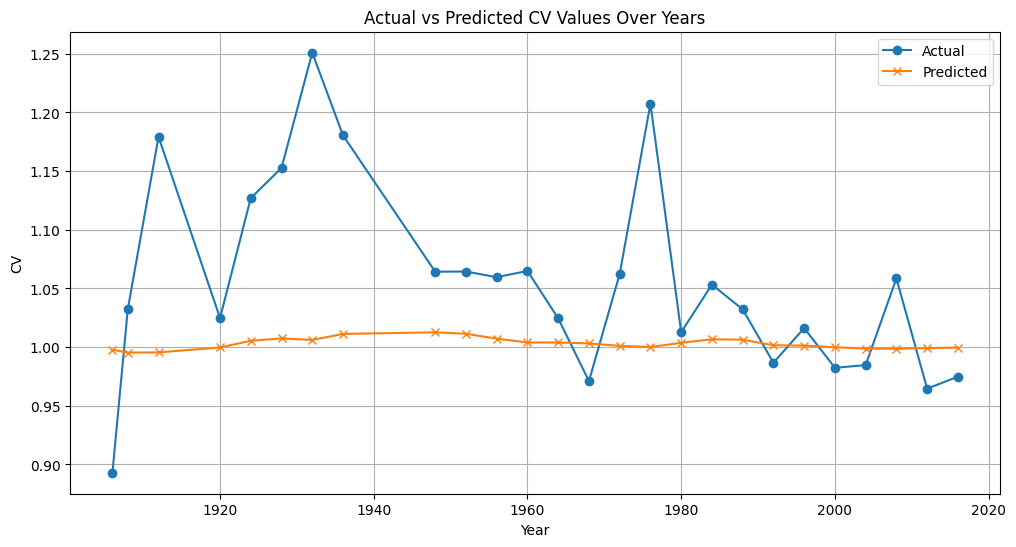

In [ ]:
plot_predictions(model=model4, data=df_Athletes_CV, window_size=3, scaler=scaler, years=df_Athletes_CV['Year'].values)

# Attempt 5: LSTM + ARIMA (Hybrid Model), not that actually bad though



In [56]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [57]:
df = data_dict['Athletics']['CV']
df.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


In [58]:
time_series_data = df['CV']

In [59]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.8 MB/s eta 0:00:00


In [60]:
import pmdarima as pm

# Perform grid search for optimal ARIMA order
model = pm.auto_arima(
    time_series_data,
    start_p=0, max_p=5,      # Range for p
    start_q=0, max_q=5,      # Range for q
    d=None,                  # Automatically determine d
    start_d=0, max_d=2,      # Differencing range
    seasonal=False,          # Use seasonal=True for SARIMA
    trace=True,              # Print search progress
    error_action='ignore',   # Ignore errors during search
    suppress_warnings=True,  # Suppress warnings
    stepwise=True            # Use stepwise algorithm for efficiency
)

# Display the best model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87.167, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-54.302, Time=0.81 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-53.264, Time=0.60 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-61.894, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.547, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-59.452, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-61.578, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-63.880, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-61.884, Time=1.23 sec
 ARIMA(

In [61]:
from statsmodels.tsa.arima.model import ARIMA

# Extract the best order
best_order = model.order  # (p, d, q)

# Fit ARIMA with the optimal order
arima_model = ARIMA(time_series_data, order=best_order).fit()

# Summary of the ARIMA model
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                     CV   No. Observations:                   29
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  34.940
Date:                Sun, 17 Nov 2024   AIC                            -63.880
Time:                        04:08:38   BIC                            -59.778
Sample:                             0   HQIC                           -62.595
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0444      0.028     36.902      0.000       0.989       1.100
ar.L1          0.4467      0.173      2.583      0.010       0.108       0.786
sigma2         0.0052      0.002      3.132      0.0

In [62]:
model_arima = ARIMA(df['CV'], order=(1,0,0))
model_arima_fit = model_arima.fit()

# Generate in-sample predictions
df['CV_arima_pred'] = model_arima_fit.predict(start=df.index[1], end=df.index[-1])

# Calculate residuals
df['CV_residual'] = df['CV'] - df['CV_arima_pred']

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Reset index for LSTM processing
df.reset_index(inplace=True)

# Handle missing values in residuals
df['CV_residual'].fillna(method='bfill', inplace=True)

# Normalize residuals
scaler = MinMaxScaler(feature_range=(0, 1))
df['CV_residual_scaled'] = scaler.fit_transform(df['CV_residual'].values.reshape(-1,1))

# Create sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 3  # Adjust as needed
data = df['CV_residual_scaled'].values
X, y = create_sequences(data, window_size)

# Split into train and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))


In [64]:
optimizer5  = Adam(learning_rate=0.0001)

In [65]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(units=1))

# Compile model
model_lstm.compile(optimizer=optimizer5, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train model
history5 = model_lstm.fit(
    X_train, y_train,
    epochs=500,
    batch_size=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3117 - val_loss: 0.1342
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3556 - val_loss: 0.1288
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2448 - val_loss: 0.1235
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3733 - val_loss: 0.1181
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3897 - val_loss: 0.1132
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2410 - val_loss: 0.1083
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3069 - val_loss: 0.1032
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2078 - val_loss: 0.0988
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2574 - val_loss: 0.0942
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1715 - val_loss: 0.0897
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2989 - val_loss: 0.0849
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [66]:
# Make predictions on the test set residuals
y_pred_residual_scaled = model_lstm.predict(X_test)

# Inverse transform the scaled residual predictions
y_pred_residual = scaler.inverse_transform(y_pred_residual_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


In [67]:
# Get ARIMA predictions for the test set
test_indices = df.index[window_size + split_index:]

arima_pred_test = df.loc[test_indices, 'CV_arima_pred'].values

# Combine ARIMA predictions with LSTM residual predictions
final_pred = arima_pred_test + y_pred_residual.flatten()


In [68]:
from sklearn.metrics import mean_squared_error, r2_score

# Actual CV values for test set
y_actual = df.loc[test_indices, 'CV'].values

# Evaluate
mse = mean_squared_error(y_actual, final_pred)
r2 = r2_score(y_actual, final_pred)

print(f"Hybrid Model Test MSE: {mse}")
print(f"Hybrid Model Test R²: {r2}")


Hybrid Model Test MSE: 0.0015103774576813703
Hybrid Model Test R²: -0.4939126611493998


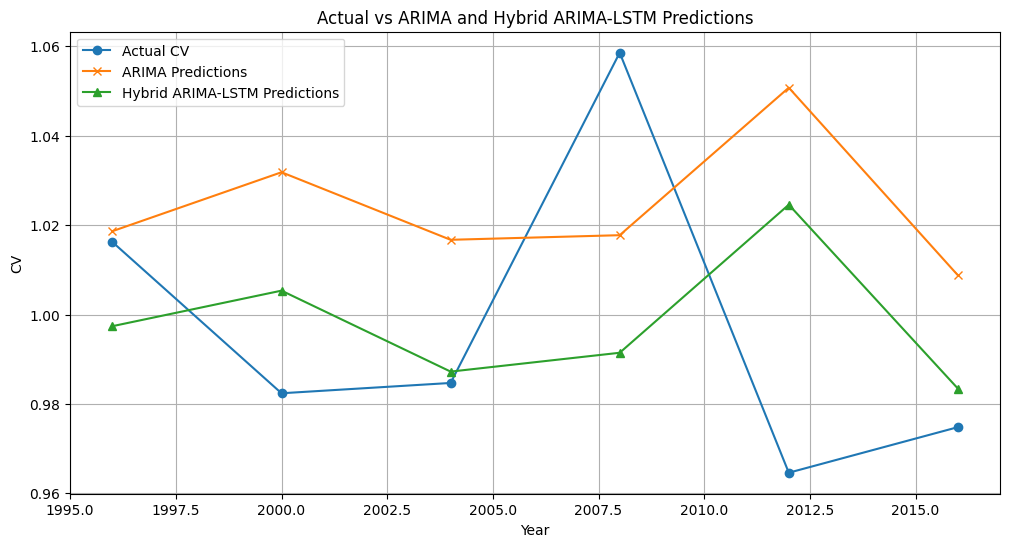

In [69]:
import matplotlib.pyplot as plt

# Years for plotting
test_years = df.loc[test_indices, 'Year'].values

plt.figure(figsize=(12,6))
plt.plot(test_years, y_actual, label='Actual CV', marker='o')
plt.plot(test_years, arima_pred_test, label='ARIMA Predictions', marker='x')
plt.plot(test_years, final_pred, label='Hybrid ARIMA-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs ARIMA and Hybrid ARIMA-LSTM Predictions')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


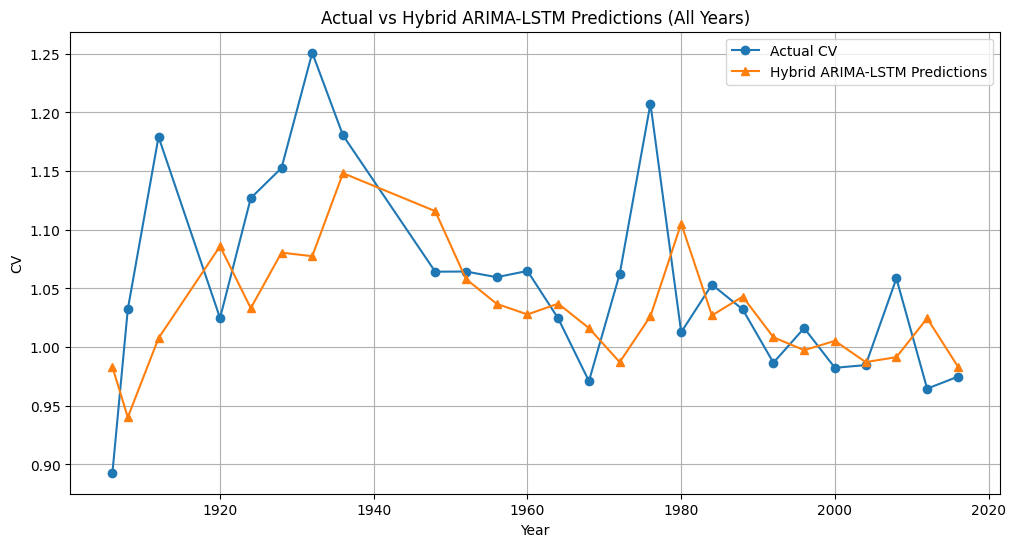

In [70]:
# Step 1: Predict ARIMA values for all years in the DataFrame
arima_all_pred = model_arima_fit.predict(start=df.index[0], end=df.index[-1])

# Step 2: Prepare residuals for LSTM predictions (all years)
# Normalize ARIMA residuals for the entire dataset
df['CV_residual'] = df['CV'] - arima_all_pred
df['CV_residual'].fillna(method='bfill', inplace=True)
df['CV_residual_scaled'] = scaler.transform(df['CV_residual'].values.reshape(-1, 1))

# Create sequences for the entire dataset
data_all = df['CV_residual_scaled'].values
X_all, _ = create_sequences(data_all, window_size)

# Reshape input for LSTM
X_all = X_all.reshape((X_all.shape[0], window_size, 1))

# Step 3: Predict LSTM residuals for all sequences
lstm_all_residual_scaled = model_lstm.predict(X_all)

# Inverse scaling of residual predictions
lstm_all_residual = scaler.inverse_transform(lstm_all_residual_scaled)

# Step 4: Combine ARIMA predictions with LSTM residual predictions
# Extend ARIMA predictions to match the LSTM output
hybrid_all_pred = arima_all_pred[window_size:] + lstm_all_residual.flatten()

# Actual values (aligned with hybrid predictions)
actual_values = df['CV'].values[window_size:]

# Step 5: Plot actual vs. hybrid predictions
import matplotlib.pyplot as plt

# Get years corresponding to hybrid predictions
years = df['Year'].values[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(years, actual_values, label='Actual CV', marker='o')
plt.plot(years, hybrid_all_pred, label='Hybrid ARIMA-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Hybrid ARIMA-LSTM Predictions (All Years)')
plt.legend()
plt.grid(True)
plt.show()


# ARIMA-LSTM Hybrid: take 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import mean_squared_error

In [9]:
df = data_dict['Athletics']['CV']
ts = df['CV']
df.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


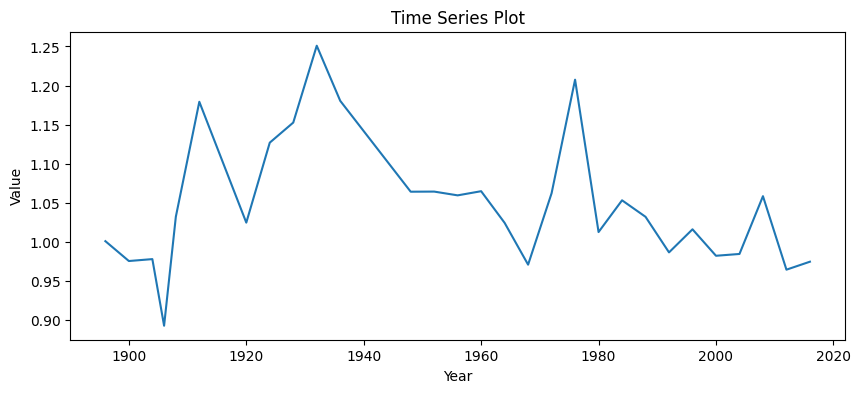

In [ ]:
# Visualize the time series
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title('Time Series Plot')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: {:.6f}'.format(result[0]))
    print('p-value: {:.6f}'.format(result[1]))
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

adf_test(ts)


ADF Statistic: -3.083080
p-value: 0.027831
The series is stationary.


In [ ]:
# Differencing the series if necessary
ts_diff = ts.diff().dropna()

# Re-run the ADF test on the differenced data
adf_test(ts_diff)


ADF Statistic: -2.724658
p-value: 0.069868
The series is non-stationary.


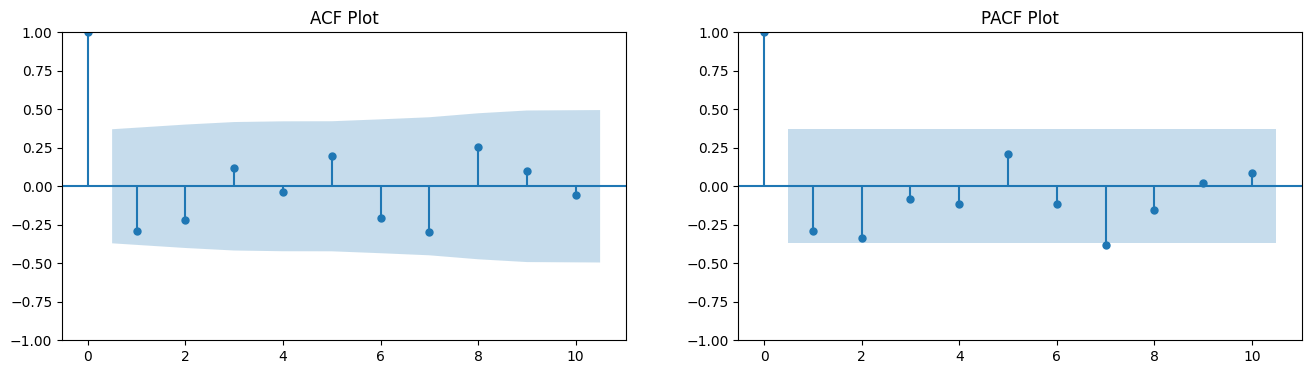

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(ts_diff, ax=axes[0], lags=10)
axes[0].set_title('ACF Plot')
plot_pacf(ts_diff, ax=axes[1], lags=10, method='ywm')
axes[1].set_title('PACF Plot')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # To ignore convergence warnings

import itertools

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

aic_values = []
parameters = []

for param in pdq:
    try:
        model = ARIMA(ts, order=param)
        results = model.fit()
        aic_values.append(results.aic)
        parameters.append(param)
    except:
        continue

# Find the model with the lowest AIC
lowest_aic = min(aic_values)
best_params = parameters[aic_values.index(lowest_aic)]
print(f'Best ARIMA order: {best_params} with AIC: {lowest_aic}')


Best ARIMA order: (1, 0, 0) with AIC: -63.880018745343435


In [ ]:
!pip install pmdarima

import pmdarima as pm

# Use auto_arima to find the optimal parameters
model_auto = pm.auto_arima(ts, start_p=0, start_q=0,
                           max_p=5, max_q=5, d=None,
                           seasonal=False, stepwise=True,
                           suppress_warnings=True, information_criterion='aic')

print(model_auto.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  34.940
Date:                Sat, 16 Nov 2024   AIC                            -63.880
Time:                        11:36:44   BIC                            -59.778
Sample:                             0   HQIC                           -62.595
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5768      0.185      3.114      0.002       0.214       0.940
ar.L1          0.4478      0.173      2.590      0.010       0.109       0.787
sigma2         0.0052      0.002      3.133      0.0

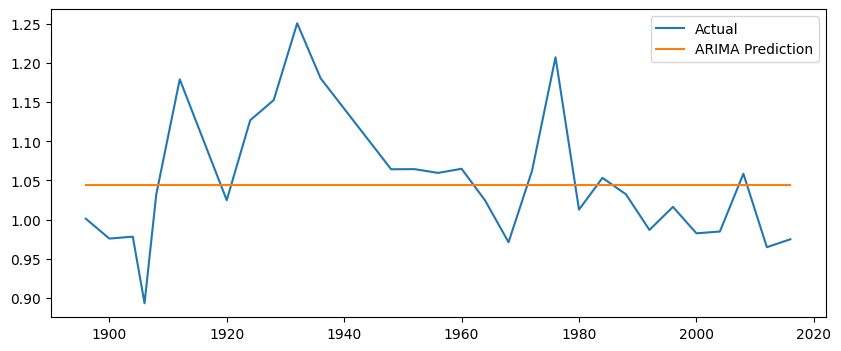

In [ ]:
# Extract the optimal (p,d,q) orders
p, d, q = model_auto.order

# Fit the ARIMA model
arima_model = ARIMA(ts, order=(p, d, q)).fit()

# ARIMA predictions
arima_pred = arima_model.predict(start=ts.index[0], end=ts.index[-1], typ='levels')

# Plot the ARIMA predictions
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Actual')
plt.plot(arima_pred, label='ARIMA Prediction')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sarimax-hybrid LSTM



In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: {:.6f}'.format(result[0]))
    print('p-value: {:.6f}'.format(result[1]))
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

adf_test(ts)


ADF Statistic: -3.083080
p-value: 0.027831
The series is stationary.


In [ ]:
# Differencing the series if necessary
ts_diff = ts.diff().dropna()

# Re-run the ADF test on the differenced data
adf_test(ts_diff)


ADF Statistic: -2.724658
p-value: 0.069868
The series is non-stationary.


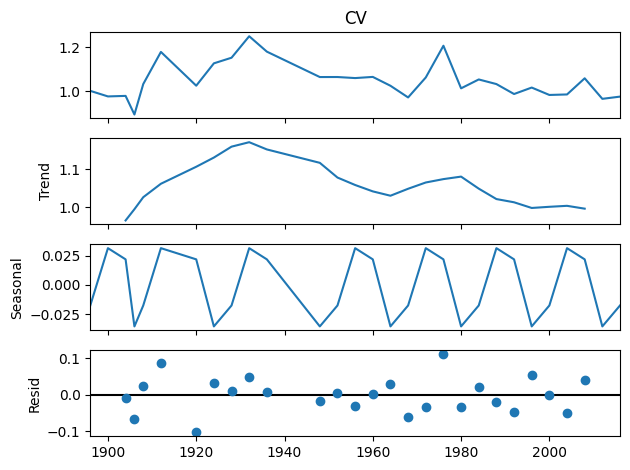

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(ts, model='additive', period=4)
decompose_result.plot()
plt.show()


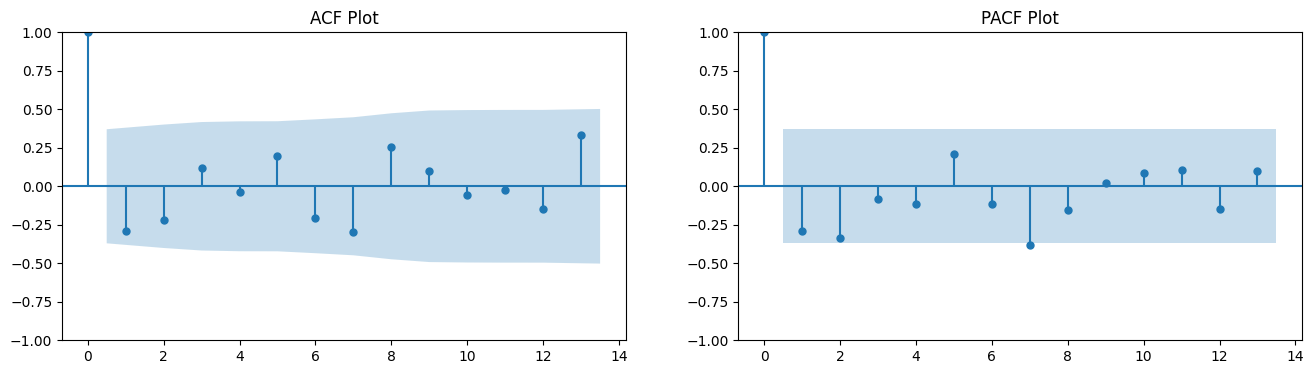

In [ ]:
# Adjust the lags based on data length
max_lag = int(len(ts) / 2) - 1  # Ensure lags < 50% of sample size

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts_diff, ax=axes[0], lags=max_lag)
axes[0].set_title('ACF Plot')
plot_pacf(ts_diff, ax=axes[1], lags=max_lag, method='ywm')
axes[1].set_title('PACF Plot')
plt.show()

In [ ]:
model_auto = pm.auto_arima(ts, start_p=0, start_q=0,
                           max_p=3, max_q=3, d=None,
                           start_P=0, start_Q=0, max_P=2, max_Q=2,
                           m=4,  # Seasonal period
                           seasonal=True, trace=True,
                           error_action='ignore', suppress_warnings=True,
                           stepwise=True, information_criterion='aic')

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=-59.452, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=-61.562, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=87.167, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=-63.547, Time=0.10 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=-28.196, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=-59.617, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=-61.894, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[4] intercept   : AIC=-61.578, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=-63.880, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=-61.882, Time=0.89 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=-59.880, Time=1.61 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=-61.884, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=-59.944, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=

In [ ]:
order = model_auto.order
seasonal_order = model_auto.seasonal_order
sarimax_model = SARIMAX(ts, order=order, seasonal_order=seasonal_order).fit(disp=False)
sarimax_pred = sarimax_model.predict(start=ts.index[0], end=ts.index[-1])

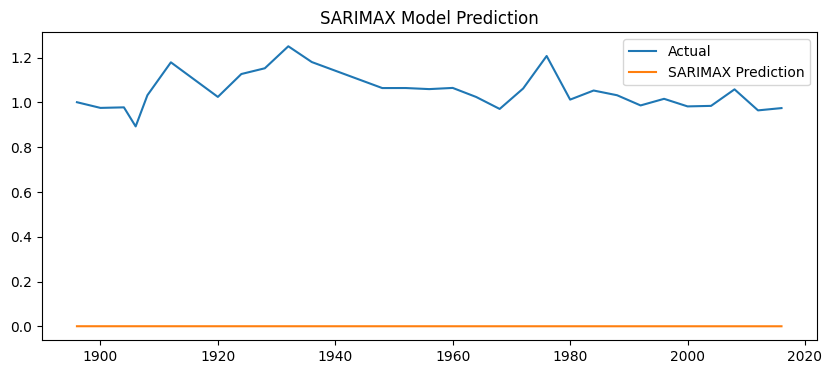

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Actual')
plt.plot(sarimax_pred, label='SARIMAX Prediction')
plt.legend()
plt.title('SARIMAX Model Prediction')
plt.show()

# GRU

In [1]:
from keras.layers import GRU, Dense, Dropout

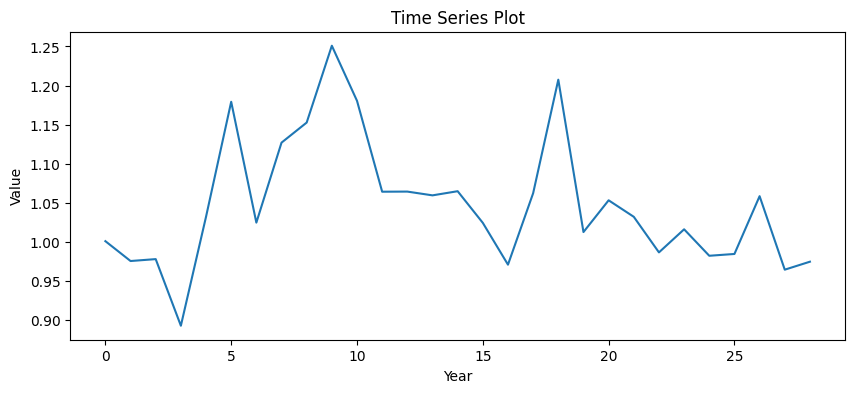

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title('Time Series Plot')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

In [11]:
# Split the data into training and testing sets
train_size = int(len(ts) * 0.8)  # Use 80% for training
test_size = len(ts) - train_size

train_ts = ts.iloc[:train_size]
test_ts = ts.iloc[train_size:]

print(f'Training data points: {len(train_ts)}')
print(f'Testing data points: {len(test_ts)}')


Training data points: 23
Testing data points: 6


In [29]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform both training and testing data
train_scaled = scaler.fit_transform(train_ts.values.reshape(-1, 1))
test_scaled = scaler.transform(test_ts.values.reshape(-1, 1))


In [30]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 1  # Using a sequence length of 1 due to limited data

# Create sequences for training
X_train, y_train = create_sequences(train_scaled, seq_length)

# Create sequences for testing
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
X_test = X_test.reshape((X_test.shape[0], seq_length, 1))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (22, 1, 1)
y_train shape: (22, 1)


In [52]:
from keras.regularizers import l2

# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=64, activation='relu', input_shape=(seq_length, 1),
              kernel_regularizer=l2(0.0005)))
model_gru.add(Dropout(0.2))  # Dropout to prevent overfitting
model_gru.add(Dense(units=1))
optimizer_gru = Adam(learning_rate=0.0001)
# Compile the model
model_gru.compile(optimizer=optimizer_gru , loss='mean_squared_error')


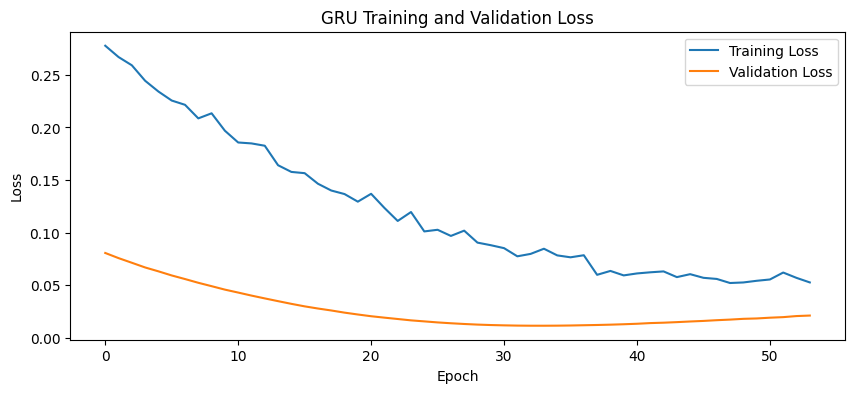

In [53]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model
history_gru = model_gru.fit(X_train, y_train, epochs=500, batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=0)

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
# Predict on training data
train_pred_scaled = model_gru.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
y_train_actual = scaler.inverse_transform(y_train)

# Predict on testing data
test_pred_scaled = model_gru.predict(X_test)
test_pred = scaler.inverse_transform(test_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


Training RMSE: 0.0969
Testing RMSE: 0.0375


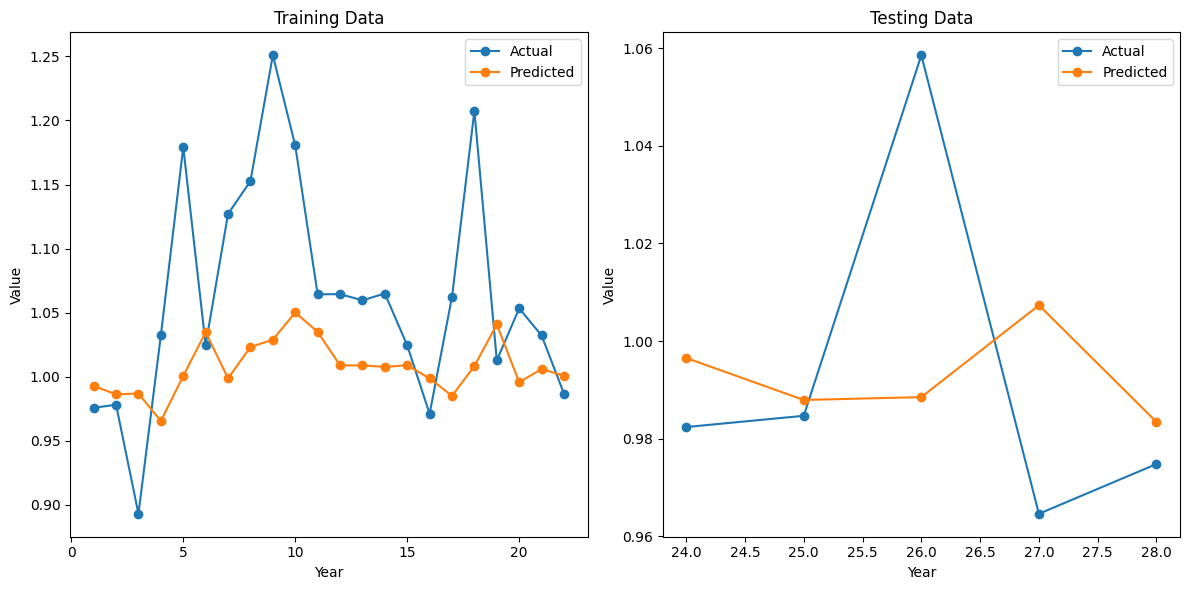

In [55]:
# Calculate RMSE for training data
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred))
print(f'Training RMSE: {train_rmse:.4f}')

# Calculate RMSE for testing data
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred))
print(f'Testing RMSE: {test_rmse:.4f}')

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training results
plt.subplot(1, 2, 1)
plt.plot(train_ts.index[seq_length:], y_train_actual, label='Actual', marker='o')
plt.plot(train_ts.index[seq_length:], train_pred, label='Predicted', marker='o')
plt.title('Training Data')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

# Plot testing results
plt.subplot(1, 2, 2)
plt.plot(test_ts.index[seq_length:], y_test_actual, label='Actual', marker='o')
plt.plot(test_ts.index[seq_length:], test_pred, label='Predicted', marker='o')
plt.title('Testing Data')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()
